In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

import sys
sys.path.append('../../../AsymptoticSolver/')
sys.path.append('..')

from Utilities.coord_func import cart2pol
from Utilities.add_var import add_u_polar, get_bg_wind
from AsymptoticSolver import polar_dft, polar_idft, pick_fourier_comp

In [2]:
%matplotlib notebook

### 1. Get data

Initial data is taken from NARVAL simulation for the 17.08.2016 1200 UTC (initialized at 0000 UTC).
Center is calculated with method of centroid pressure.

__Constants:__  
lev_start: Level from where the calculation should start  
km: Radius around the cyclone center  
r_earth: Radius of earth  
r_rad: Radius around the cyclone center in radians

In [3]:
lev_start= 45             
km       = 250                           
r_earth  = 6371                     
r_rad    = km / r_earth

In [95]:
# Data for centerline
center_file       = "../Data/center_fiona.npy" 
center = np.load(center_file)

# Initial data
ds_orig = xr.open_dataset('../../../../init_data/dei4_NARVALII_2016081700_fg_DOM01_ML_0012.nc')
ds_ideal = xr.open_dataset('../../../../init_data/init_idealized_DOM01_2016081712.nc')

# Number of levels in file (highest index is lowest level -> p-system)
nlev = len(ds_orig.height.values)
height = ds_orig.z_ifc.values

### 2. Polar coordinate transformation

Select a variable of interest because a memory error occurse when trying to manipulate the whole data set. Create a new polar coord. grid to interpolate the lon-lat data onto.

In [97]:
#var_da = ds_orig.temp[0]
var_da= ds_ideal.temp[0]
#var_da = ds_orig.temp[0]

# Extract region containing cyclone
lonlat_box = {'lon_up':-0.57,'lon_down':-0.68, 'lat_up': 0.17, 'lat_down': 0.30}

 # Select region of interest
var_da = var_da.where(var_da['clon'] < lonlat_box['lon_up'], drop=True)
var_da = var_da.where(var_da['clon'] > lonlat_box['lon_down'], drop=True)
var_da = var_da.where(var_da['clat'] > lonlat_box['lat_up'], drop=True)
var_da = var_da.where(var_da['clat'] < lonlat_box['lat_down'], drop=True)



In [98]:
cellID = var_da.ncells.values

lon = var_da.clon.values
lat = var_da.clat.values

# Create new grid
r_grid = np.linspace(0,r_rad,1000).transpose()
phi_grid = np.linspace(-np.pi,np.pi,1000,endpoint=False)
r_grid_da = xr.DataArray(r_grid, coords=[('r', r_grid)])
phi_grid_da = xr.DataArray(phi_grid, coords=[('phi', phi_grid)])

In [99]:
# Create array to contain the azimuthal mean of the temp around the cyclone center. 
# Center has to be set as fixed point otherwise the plot is misleading. I can take the average center
center_mean = [np.mean(center[1:,0]), np.mean(center[1:,1])]

In [100]:
center_mean

[-0.625647297501564, 0.23598667681217195]

In [101]:
# Calculate r and phi 
r,phi = cart2pol(lon,lat,center_mean)

x_grid = center_mean[0] + r_grid_da*np.cos(phi_grid_da)
y_grid = center_mean[1] + r_grid_da*np.sin(phi_grid_da)

# Create new lon and lat positions using polar coordinates 
# (necessary to have all points for interpolation method):
x_polar = [center_mean[0] + r_grid[j]*np.cos(phi_grid) \
            for j in range(len(r_grid))]
x_polar = np.asarray(x_polar).reshape((1,len(r_grid)*len(r_grid)))
y_polar = [center_mean[1] + r_grid[j]*np.sin(phi_grid) \
            for j in range(len(r_grid))]
y_polar = np.asarray(y_polar).reshape((1,len(r_grid)*len(r_grid)))

lonlat_points = np.asarray([var_da.clon.values[:], var_da.clat.values[:]]).transpose()
polar_points = np.asarray([x_polar, y_polar]).reshape((2,len(x_polar[0]))).transpose()

In [102]:
var_remap = np.empty((len(var_da.height), len(r_grid),len(phi_grid)))

In [103]:
for lev_index in range(0,len(var_da.height)):

    values = var_da.values[lev_index]

    # remap variables for circles with constant radius around center
    var_remap_single = griddata(lonlat_points, values, polar_points, method='cubic')
    var_remap_single = var_remap_single.reshape((len(r_grid),len(phi_grid)))

    var_remap[lev_index] = var_remap_single
 

In [104]:
# Add polar coordinates as dimensions
var_polar_da = xr.DataArray(var_remap, coords={ 'height': ('height', var_da.height), 'r':('r',r_grid), \
                    'phi':('phi', phi_grid), 'x': x_grid , 'y': y_grid }, \
                    dims={'height': var_da.height, 'r': r_grid, 'phi':phi_grid })
var_polar_da = var_polar_da.fillna(0.)

In [105]:
temp_mean = np.empty(len(var_da.height))
temp_pert_r = np.empty((len(var_da.height), len(r_grid)))

In [106]:
for l in range(0, len(var_da.height)):
    temp_mean[l] = ds_orig.temp.isel(height=l).mean()
    for i in range(0,len(var_polar_da.r)):
        #temp_pert_r[l,i] = temp_mean[l] - var_polar_da.isel(height=l, r=i).mean()
        tmp_temp = temp_mean[l] - var_polar_da.isel(height=l, r=i)
        temp_pert_r[l,i] = tmp_temp.mean()

<IPython.core.display.Javascript object>


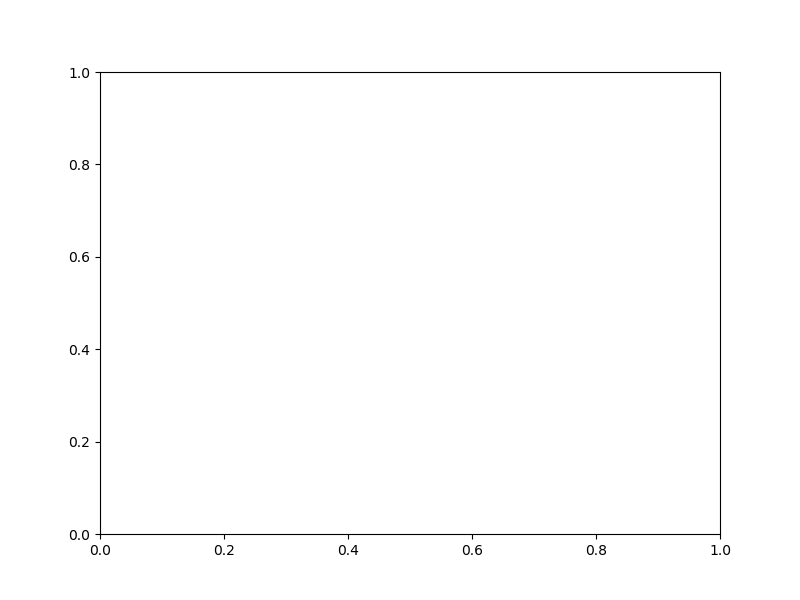

AttributeError: 'tuple' object has no attribute 'add_subplot'

In [108]:
# selection to plot
temp_tropo = temp_pert_r[35:]
temp_tropo_ref = temp_pert_r_ref[35:]
z_ifc_tropo = ds_orig.z_ifc.values[35:-1,0]/1000
radius = var_polar_da.r.values*6371

fig = plt.subplots(figsize=(8,6))
ax = fig.add_subplot(121)
cmesh = plt.pcolormesh(radius, z_ifc_tropo, np.flipud(temp_tropo)
                       , cmap="Spectral_r")
plt.ylabel('Height (km)')
cbar = plt.colorbar(cmesh, ax=ax)
cbar.ax.set_ylabel(r'')

ax = fig.add_subplot(122)
cmesh = plt.pcolormesh(radius, z_ifc_tropo, np.flipud(temp_tropo_ref)
                       , cmap="Spectral_r")
#CS = ax.contour(lon,lat, sst, levels, linewidths=0.7, colors='k')
plt.xlabel('Radius (km)')
cbar = plt.colorbar(cmesh, ax=ax)
cbar.ax.set_ylabel(r' Temperature (K)')

#plt.clabel(CS, inline=1)
#ax.clabel(CS,fmt='%2.1f', inline=1, fontsize=13)

In [59]:
#temp_pert_r_ref = temp_pert_r.copy()

array([[ 0.57592471,  0.57458053,  0.57195937, ..., -0.62387914,
        -0.62504593, -0.62620068],
       [ 0.71044762,  0.71046466,  0.70863096, ..., -0.69199355,
        -0.69348657, -0.69501433],
       [-0.02674133, -0.02688689, -0.03032635, ..., -0.3123596 ,
        -0.31405811, -0.31600978],
       ...,
       [-0.27701041, -0.27260859, -0.28072089, ..., -0.54173737,
        -0.54296974, -0.5439561 ],
       [-0.2774832 , -0.27317995, -0.28141435, ..., -0.53932924,
        -0.54050952, -0.54145192],
       [-0.27123716, -0.26698334, -0.27529015, ..., -0.50206358,
        -0.50319232, -0.5041039 ]])

In [50]:
temp_pert_r[-1]

array([-2.71237157e-01, -2.66983341e-01, -2.75290153e-01, -2.90062955e-01,
       -3.03481835e-01, -3.14928677e-01, -3.26644919e-01, -3.33853200e-01,
       -3.38321054e-01, -3.40920201e-01, -3.39219145e-01, -3.33517217e-01,
       -3.25123374e-01, -3.18613697e-01, -3.21909567e-01, -3.26154107e-01,
       -3.32733879e-01, -3.46281534e-01, -3.60077598e-01, -3.72805680e-01,
       -3.83125438e-01, -3.89512577e-01, -3.91826681e-01, -3.89529479e-01,
       -3.82212699e-01, -3.74408793e-01, -3.67248241e-01, -3.64245682e-01,
       -3.65979780e-01, -3.72493642e-01, -3.80943191e-01, -3.89059332e-01,
       -3.97013771e-01, -4.03218579e-01, -4.07680705e-01, -4.07710240e-01,
       -4.01668823e-01, -3.94528529e-01, -3.89566180e-01, -3.86109042e-01,
       -3.83277343e-01, -3.82003400e-01, -3.82606861e-01, -3.84531373e-01,
       -3.87202905e-01, -3.90169162e-01, -3.91726285e-01, -3.90818369e-01,
       -3.87677746e-01, -3.82957614e-01, -3.76104692e-01, -3.68401465e-01,
       -3.62399662e-01, -